In [115]:
import pandas as pd
df= pd.read_excel("online_retail_II.xlsx")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [117]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [119]:
print("Non-positive Quantity:", (df['Quantity'] <= 0).sum())
print("Non-positive Price:", (df['Price'] <= 0).sum())

Non-positive Quantity: 12326
Non-positive Price: 3690


In [121]:
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]
df = df.dropna(subset=['Customer ID'])
df['TotalAmount'] = df['Quantity'] * df['Price']

df['Customer ID'] = df['Customer ID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [123]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalAmount    0
dtype: int64

In [131]:
rfm_data = df[['Customer ID', 'Invoice', 'InvoiceDate', 'TotalAmount']].copy()
rfm_data.head()

,Customer ID,Invoice,InvoiceDate,TotalAmount
0,13085,489434,2009-12-01 07:45:00,83.4
1,13085,489434,2009-12-01 07:45:00,81.0
2,13085,489434,2009-12-01 07:45:00,81.0
3,13085,489434,2009-12-01 07:45:00,100.8
4,13085,489434,2009-12-01 07:45:00,30.0


In [133]:
import sqlite3

conn = sqlite3.connect("retail_clean.db")
rfm_data.to_sql("transactions", conn, if_exists="replace", index=False)

407664

In [135]:
pd.read_sql_query("SELECT * FROM transactions LIMIT 5;", conn)

,Customer ID,Invoice,InvoiceDate,TotalAmount
0,13085,489434,2009-12-01 07:45:00,83.4
1,13085,489434,2009-12-01 07:45:00,81.0
2,13085,489434,2009-12-01 07:45:00,81.0
3,13085,489434,2009-12-01 07:45:00,100.8
4,13085,489434,2009-12-01 07:45:00,30.0


In [161]:
query = "SELECT MAX(InvoiceDate) AS LatestDate FROM transactions;"
latest_date = pd.read_sql_query(query, conn)
latest_invoice_date = latest_date['LatestDate'][0]
print("Latest Invoice Date:", latest_invoice_date)

Latest Invoice Date: 2010-12-09 20:01:00


In [167]:
recency_query = f"""
SELECT 
    [Customer ID],
    ROUND(julianday('{latest_invoice_date}') - julianday(MAX(InvoiceDate))) AS Recency
FROM transactions
GROUP BY [Customer ID]
ORDER BY Recency ASC
"""
recency_df = pd.read_sql_query(recency_query, conn)
recency_df.head()

,Customer ID,Recency
0,12429,0.0
1,12481,0.0
2,12494,0.0
3,12621,0.0
4,12682,0.0


In [165]:
frequency_query = """
SELECT 
    [Customer ID],
    COUNT(DISTINCT Invoice) AS Frequency
FROM transactions
GROUP BY [Customer ID]
ORDER BY Frequency DESC
"""

frequency_df = pd.read_sql_query(frequency_query, conn)
frequency_df.head()


,Customer ID,Frequency
0,14911,205
1,17850,155
2,12748,144
3,15311,121
4,13089,109


In [65]:
monetary_query = """
SELECT 
    [Customer ID],
    ROUND(SUM(TotalAmount), 2) AS Monetary
FROM transactions
GROUP BY [Customer ID]
ORDER BY Monetary DESC
"""
monetary_df = pd.read_sql_query(monetary_query, conn)
monetary_df.head()


,CustomerID,Monetary
0,CUST0003,5914.30
1,CUST0208,5378.90
2,CUST0125,5284.72
3,CUST0301,5022.41
4,CUST0214,4956.54


In [179]:

rfm_query = f"""
SELECT 
    r.[Customer ID] AS CustomerID,
    ROUND(julianday('{latest_order_date}') - julianday(r.LastPurchaseDate)) AS Recency,
    f.Frequency,
    m.Monetary
FROM 
    (SELECT [Customer ID], MAX(InvoiceDate) AS LastPurchaseDate
     FROM transactions
     GROUP BY [Customer ID]) r

JOIN 
    (SELECT [Customer ID], COUNT(DISTINCT Invoice) AS Frequency
     FROM transactions
     GROUP BY [Customer ID]) f
ON r.[Customer ID] = f.[Customer ID]

JOIN 
    (SELECT [Customer ID], ROUND(SUM(TotalAmount), 2) AS Monetary
     FROM transactions
     GROUP BY [Customer ID]) m
ON r.[Customer ID] = m.[Customer ID]

ORDER BY Recency ASC;
"""

rfm_df = pd.read_sql_query(rfm_query, conn)
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12429,0.0,5,3735.51
1,12481,0.0,6,6765.07
2,12494,0.0,3,626.77
3,12621,0.0,16,11086.14
4,12682,0.0,23,11745.69


In [181]:

rfm = rfm_df.copy()
r_bins = min(rfm['Recency'].nunique(), 5)
f_bins = min(rfm['Frequency'].nunique(), 5)
m_bins = min(rfm['Monetary'].nunique(), 5)

rfm['R_Score'] = pd.qcut(rfm['Recency'], q=r_bins, labels=list(range(r_bins, 0, -1)), duplicates='drop').astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=f_bins, labels=list(range(1, f_bins + 1)), duplicates='drop').astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), q=m_bins, labels=list(range(1, m_bins + 1)), duplicates='drop').astype(int)

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12429,0.0,5,3735.51,5,4,5,545
1,12481,0.0,6,6765.07,5,4,5,545
2,12494,0.0,3,626.77,5,3,3,533
3,12621,0.0,16,11086.14,5,5,5,555
4,12682,0.0,23,11745.69,5,5,5,555


In [199]:
def segment_customer(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3:
        return 'Loyal'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Hibernating'
    elif r <= 2 and f <= 2:
        return 'At Risk'
    elif r >= 4 and f <= 2:
        return 'New Customers'
    elif f >= 4:
        return 'Frequent Buyers'
    elif m >= 4:
        return 'Big Spenders'
    else:
        return 'Neutral'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

rfm[['CustomerID', 'RFM_Score', 'Segment']].head()


,CustomerID,RFM_Score,Segment
0,12429,545,Champions
1,12481,545,Champions
2,12494,533,Loyal
3,12621,555,Champions
4,12682,555,Champions


In [201]:
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Customer Count']
segment_counts

,Segment,Customer Count
0,Champions,913
1,Loyal,858
2,Hibernating,774
3,Neutral,612
4,New Customers,524
5,Frequent Buyers,432
6,At Risk,113
7,Big Spenders,86


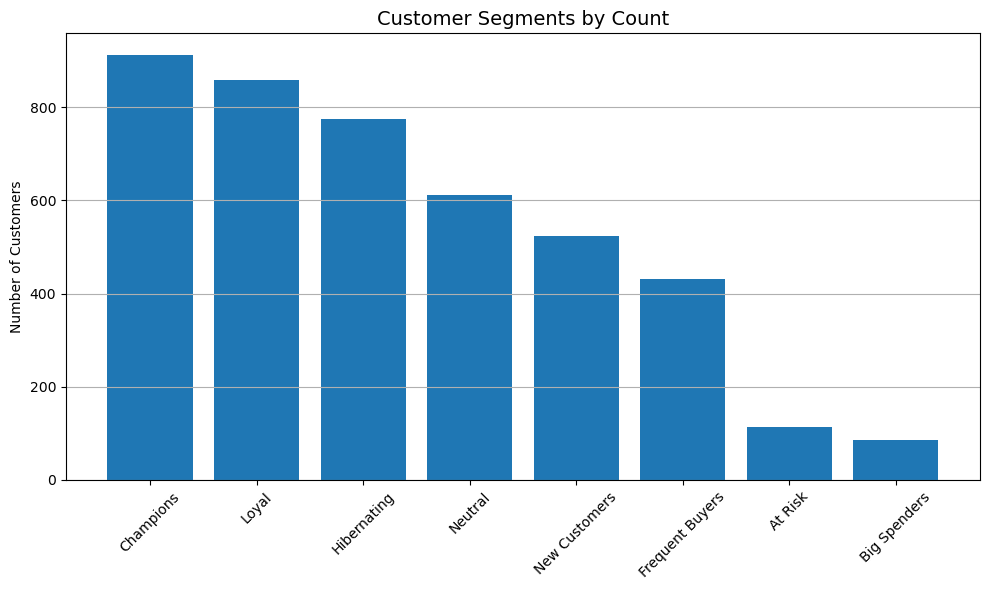

In [203]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(segment_counts['Segment'], segment_counts['Customer Count'])
plt.title("Customer Segments by Count", fontsize=14)
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [205]:
rfm.to_csv("rfm_segmented_customers.csv", index=False)